In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm

from rbm.lattices import Fine_RBM, A1_RBM
from rg.monotone import ResidualMLP
from utils.losses import free_energy_difference
from utils.newton import find_root

In [2]:
device = torch.device('cpu')

# Models

In [3]:
C = ResidualMLP(
    in_channels=1, 
    device=device
)

fine = Fine_RBM(device=device)

coarse = A1_RBM(device=device)

# Training

In [4]:
optimizer = torch.optim.Adam(C.parameters())

In [5]:
epochs = 2048
batch_n = 4
k = 32

In [10]:
C.train()

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    loss = 0
    for batch in range(batch_n):
        fine.J = torch.abs(torch.randn(1, requires_grad=False) + 0.8 * 2)
        coarse.J = fine.J - C.grad(fine.J)

        loss += free_energy_difference(
            fine, coarse, 
            batch_n=1, k=k
        )
    loss /= batch_n
    
    loss.backward()
    optimizer.step()

100%|███████████████████████████████████████| 2048/2048 [00:41<00:00, 49.78it/s]


Critical Point: 0.8793641924858093


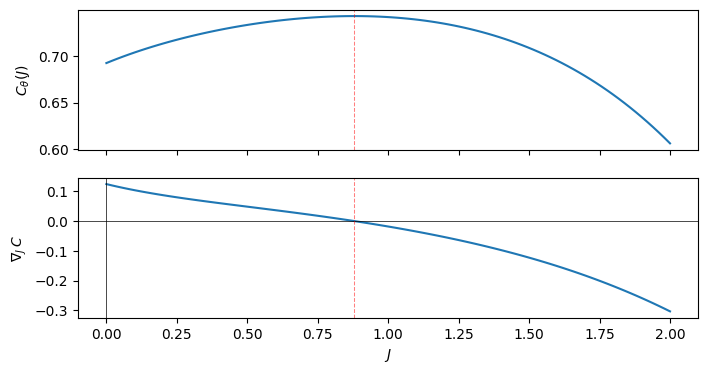

In [11]:
C.eval()

J = torch.linspace(0, 2, 100).unsqueeze(1)

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

ax0.plot(J, C(J).detach())
ax0.set_ylabel(r'$C_{\theta}(J)$')

ax1.plot(J, torch.cat([C.grad(j)for j in J]).detach())
ax1.set_xlabel(r'$J$')
ax1.set_ylabel(r'$\nabla_J \: C$')
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axvline(0, color='black', linewidth=0.5)

J_c = find_root(torch.tensor([1.]), C.grad)
print(f'Critical Point: {J_c}')
ax0.axvline(J_c, c='r', alpha=0.5, linestyle='dashed', linewidth=0.75)
ax1.axvline(J_c, c='r', alpha=0.5, linestyle='dashed', linewidth=0.75);